# Dataset Exploration

In [91]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy
from rich import inspect
from tqdm import tqdm

# torch
import torch

# monai
import monai
from monai.data import ImageDataset, ThreadDataLoader

# sys path append
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [92]:
# rtk
from rtk import repl
from rtk.config import (
    set_hydra_configuration,
    Configuration,
    DatasetConfiguration,
    JobConfiguration,
)
from rtk.utils import login, hydra_instantiate

In [93]:
repl.install(show_locals=False)
monai.config.print_config()

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/nicoleg/anaconda3/envs/ttk-env/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
ITK version: 5.3.0
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: 4.33.3
mlflow version: 2.6.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

### Constant setup

In [94]:
# configs
config_name = "tests"
config_path = "../configs/"
config_dir = os.path.abspath(config_path)


In [95]:
cfg: Configuration = set_hydra_configuration(
        config_name=config_name,
        init_method_kwargs={"config_dir": config_dir},
        ConfigurationInstance=Configuration,
    )
dataset_cfg: DatasetConfiguration = cfg.datasets
job_cfg: JobConfiguration = cfg.job
monai.utils.set_determinism(seed=job_cfg.random_state)
cfg

[00:09:46] INFO     rtk.config: Creating configuration: 'tests'                                       ]8;id=288389;file:///home/nicoleg/workspaces/teddytoolkit/rtk/config.py\config.py]8;;\:]8;id=256787;file:///home/nicoleg/workspaces/teddytoolkit/rtk/config.py#289\289]8;;\
                    [0m                                                                                            


Configuration(
    date='2023-10-11',
    postfix='',
    timestamp='00-09-46',
    datasets={'dim': 229, 'extension': '.png', 'index': 'Image Index', 'labels': ['No Finding', 'Pneumonia'], 'target': 'Finding Labels', 'patient_data': '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/Data_Entry_2017.csv', 'scan_data': '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/', 'encoding': {'No Finding': 0, 'Pneumonia': 1}, 'instantiate': {'_target_': 'monai.data.ImageDataset'}, 'dataloader': {'_target_': 'monai.data.ThreadDataLoader', 'batch_size': 16, 'num_workers': 24}, 'preprocessing': {'resample_value': 1, 'sample_to_value': -1, 'use_sampling': False}, 'transforms': {'load': [{'_target_': 'monai.transforms.ScaleIntensity'}, {'_target_': 'monai.transforms.EnsureChannelFirst'}, {'_target_': 'monai.transforms.EnsureType', 'track_meta': True}, {'_target_': 'monai.transforms.Resize', 'spatial_size': ['${datasets.dim}', '${datasets.dim}']}], 'train': [{'_

In [96]:
patient_path = dataset_cfg.patient_data
patient_path

'/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle_RGB/Data_Entry_2017.csv'

In [97]:
scan_path = "/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/"
scan_path

'/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/'

In [98]:
# display single image
# depth_slice = scan.shape[2] // 2
# display_scan_slice = scan[:, :, depth_slice].numpy()
# plt.imshow(display_scan_slice, cmap="bone");

# Exploration

In [99]:
# https://stackoverflow.com/questions/339007/how-do-i-pad-a-string-with-zeroes
index = dataset_cfg.index
target = dataset_cfg.target
label_encoding = 1
patient_df = pd.read_csv(patient_path).set_index(index)
label_path = os.path.join(scan_path, f"images_{label_encoding:03}", "images")
os.listdir(label_path)



[
    '00000096_001.png',
    '00001250_005.png',
    '00001220_000.png',
    '00000419_000.png',
    '00000654_001.png',
    '00000827_016.png',
    '00000468_025.png',
    ... +4992
]

In [100]:
# subset to the indicated indices in the label encoding
filename_matches = {"image_files": [], index: []}

for filename in os.listdir(label_path):
    filename_matches[index].append(filename)
    filename_matches["image_files"].append(os.path.join(label_path, filename))

filename_matches



{
    'image_files': [
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000096_001.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00001250_005.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00001220_000.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000419_000.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000654_001.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000827_016.png',
        '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_14_Kaggle/images_001/images/00000468_025.png',
        ... +4992
    ],
    'Image Index': [
        '00000096_001.png',
        '00001250_005.png',
        '00001220_000.png',
        '00000419_000.png',
        '00000654_001.png',
        '0000

## Wrangling data

In [101]:
patient_df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
Image Index,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [102]:
def unpack_images():
    """"""

    filename_matches = {"image_files": [], index: []}

    for encoding in range(1, 13):
        label_path = os.path.join(scan_path, f"images_{encoding:03}", "images")

        for filename in os.listdir(label_path):
            filename_matches[index].append(filename)
            filename_matches["image_files"].append(os.path.join(label_path, filename))

    return pd.DataFrame.from_dict(filename_matches, orient="columns").set_index(index)

matches = unpack_images()
len(matches), matches.head()


(
    112120,
                                                            image_files
Image Index                                                        
00000096_001.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00001250_005.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00001220_000.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000419_000.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000654_001.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...
)

In [103]:
patient_df = patient_df.merge(matches, on=index, how="inner")
patient_df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_files
Image Index,,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...


In [104]:
with open(os.path.join(scan_path, "train_val_list.txt"), "r") as f:
    train_val_list = f.readlines()

train_val_list


[
    '00000001_000.png\n',
    '00000001_001.png\n',
    '00000001_002.png\n',
    '00000002_000.png\n',
    '00000004_000.png\n',
    '00000005_000.png\n',
    '00000005_001.png\n',
    ... +86517
]

In [105]:
train_val_list = [idx.strip() for idx in train_val_list]
train_val_list


[
    '00000001_000.png',
    '00000001_001.png',
    '00000001_002.png',
    '00000002_000.png',
    '00000004_000.png',
    '00000005_000.png',
    '00000005_001.png',
    ... +86517
]

In [106]:
# do the same for the test list
with open(os.path.join(scan_path, "test_list.txt"), "r") as f:
    test_list = f.readlines()
    test_list = [idx.strip() for idx in test_list]

test_list


[
    '00000003_000.png',
    '00000003_001.png',
    '00000003_002.png',
    '00000003_003.png',
    '00000003_004.png',
    '00000003_005.png',
    '00000003_006.png',
    ... +25589
]

In [107]:
train_df = patient_df[patient_df.index.isin(train_val_list)]
test_df = patient_df[patient_df.index.isin(test_list)]
train_df.head()

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_files
Image Index,,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...


### Subsetting

In [108]:
# subsetting
labels = dataset_cfg.labels
labels

['No Finding', 'Pneumonia']

In [109]:
from pandas import DataFrame, Series

train_subset_condition = train_df[target].str.contains(labels[0]) | train_df[target].str.contains(labels[1])
test_subset_condition = test_df[target].str.contains(labels[0]) | test_df[target].str.contains(labels[1])
train_df = train_df[train_subset_condition]
test_df = test_df[test_subset_condition]
train_df.head(10)


,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_files
Image Index,,,,,,,,,,,,
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_001.png,No Finding,1,5,69,F,AP,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_002.png,No Finding,2,5,69,F,AP,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_003.png,No Finding,3,5,69,F,PA,2992,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_004.png,No Finding,4,5,70,F,PA,2986,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_005.png,No Finding,5,5,70,F,PA,2514,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000006_000.png,No Finding,0,6,81,M,PA,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000007_000.png,No Finding,0,7,82,M,PA,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...


In [110]:
# unique
from rtk.utils import get_console

console = get_console()

console.print("Train dataset description:")
console.print(train_df[target].unique())
console.print(train_df[target].nunique())
console.print(train_df[target].value_counts())

Train dataset description:

['No Finding' 'Nodule|Pneumonia'
 'Edema|Effusion|Infiltration|Pleural_Thickening|Pneumonia' 'Pneumonia'
 'Infiltration|Pneumonia' 'Fibrosis|Infiltration|Nodule|Pneumonia'
 'Edema|Infiltration|Pneumonia' 'Fibrosis|Infiltration|Pneumonia'
 'Effusion|Infiltration|Pleural_Thickening|Pneumonia'
 'Atelectasis|Pneumonia' 'Fibrosis|Pneumonia'
 'Pleural_Thickening|Pneumonia' 'Edema|Effusion|Nodule|Pneumonia'
 'Effusion|Pneumonia' 'Edema|Effusion|Pneumonia'
 'Effusion|Infiltration|Pneumonia'
 'Atelectasis|Emphysema|Infiltration|Pneumonia'
 'Edema|Effusion|Infiltration|Pneumonia' 'Effusion|Fibrosis|Pneumonia'
 'Emphysema|Pneumonia' 'Edema|Pleural_Thickening|Pneumonia'
 'Consolidation|Infiltration|Pneumonia'
 'Atelectasis|Infiltration|Pneumonia' 'Edema|Pneumonia'
 'Infiltration|Nodule|Pneumonia' 'Emphysema|Infiltration|Pneumonia'
 'Emphysema|Infiltration|Pleural_Thickening|Pneumonia'
 'Cardiomegaly|Pneumonia' 'Atelectasis|Nodule|Pneumonia'
 'Atelectasis|Effusion|Pneumonia'
 'Consolidation|Effusion|Infiltration|Pneumonia'
 'Atelectasis|Edema|Effusion|Pneumonia|Pneumothorax'
 'Atelectasis|Effusion|Infiltration|Pneumonia' 'Mass|Nodule|Pneumonia'
 'Atelectasis|Consolidation|Edema|Infiltration|Pneumonia'
 'Atelectasis|Consolidation|Infiltration|Pneumonia' 'Mass|Pneumonia'
 'Effusion|Pleural_Thickening|Pneumonia'
 'Atelectasis|Cardiomegaly|Pneumonia' 'Edema|Mass|Pneumonia'
 'Infiltration|Mass|Pneumonia' 'Infiltration|Pneumonia|Pneumothorax'
 'Consolidation|Pneumonia' 'Atelectasis|Consolidation|Pneumonia'
 'Edema|Infiltration|Pleural_Thickening|Pneumonia'
 'Edema|Infiltration|Mass|Pneumonia'
 'Effusion|Fibrosis|Infiltration|Pleural_Thickening|Pneumonia'
 'Atelectasis|Consolidation|Mass|Pneumonia' 'Atelectasis|Mass|Pneumonia'
 'Atelectasis|Infiltration|Pleural_Thickening|Pneumonia'
 'Atelectasis|Edema|Effusion|Infiltration|Pneumonia'
 'Consolidation|Effusion|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumonia'
 'Cardiomegaly|Consolidation|Pneumonia' 'Cardiomegaly|Effusion|Pneumonia'
 'Atelectasis|Infiltration|Mass|Pneumonia'
 'Atelectasis|Emphysema|Pneumonia'
 'Effusion|Infiltration|Mass|Nodule|Pneumonia'
 'Atelectasis|Edema|Infiltration|Pneumonia' 'Pneumonia|Pneumothorax'
 'Atelectasis|Effusion|Pneumonia|Pneumothorax'
 'Consolidation|Effusion|Mass|Pneumonia' 'Edema|Nodule|Pneumonia'
 'Effusion|Mass|Pneumonia|Pneumothorax' 'Consolidation|Effusion|Pneumonia'
 'Atelectasis|Consolidation|Infiltration|Mass|Pneumonia'
 'Consolidation|Edema|Infiltration|Pneumonia'
 'Cardiomegaly|Effusion|Infiltration|Mass|Pneumonia'
 'Edema|Infiltration|Nodule|Pneumonia'
 'Effusion|Infiltration|Mass|Pneumonia'
 'Cardiomegaly|Edema|Effusion|Infiltration|Mass|Pleural_Thickening|Pneumonia'
 'Atelectasis|Consolidation|Edema|Pneumonia'
 'Edema|Infiltration|Pneumonia|Pneumothorax'
 'Consolidation|Mass|Nodule|Pneumonia'
 'Consolidation|Infiltration|Nodule|Pneumonia'
 'Atelectasis|Cardiomegaly|Edema|Effusion|Infiltration|Nodule|Pneumonia'
 'Atelectasis|Consolidation|Edema|Effusion|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumonia'
 'Effusion|Mass|Pneumonia' 'Effusion|Emphysema|Infiltration|Pneumonia'
 'Edema|Emphysema|Infiltration|Pneumonia'
 'Cardiomegaly|Infiltration|Pneumonia'
 'Effusion|Infiltration|Nodule|Pneumonia' 'Atelectasis|Edema|Pneumonia'
 'Emphysema|Pneumonia|Pneumothorax'
 'Atelectasis|Effusion|Infiltration|Pneumonia|Pneumothorax'
 'Effusion|Infiltration|Mass|Pleural_Thickening|Pneumonia'
 'Consolidation|Nodule|Pneumonia'
 'Atelectasis|Consolidation|Effusion|Pneumonia']

87

Finding Labels
No Finding                                           50500
Pneumonia                                              234
Infiltration|Pneumonia                                 127
Atelectasis|Pneumonia                                   82
Edema|Infiltration|Pneumonia                            68
                                                     ...  
Effusion|Infiltration|Mass|Nodule|Pneumonia              1
Pneumonia|Pneumothorax                                   1
Effusion|Mass|Pneumonia|Pneumothorax                     1
Cardiomegaly|Effusion|Infiltration|Mass|Pneumonia        1
Atelectasis|Consolidation|Effusion|Pneumonia             1
Name: count, Length: 87, dtype: int64

## Pneumonia to metaclass

In [112]:
# {label: i for i, label in enumerate(dataset_cfg.labels)}
def transform_labels_to_metaclass(df: pd.DataFrame, target_name: str, metaclass: dict):
    """
    Transform the labels to the metaclass.
    """

    def _transform_to_metaclass(x, metaclass: dict):
        """
        Transform the label to the metaclass.
        """
        for new_class, old_classes in metaclass.items():
            if new_class in x:
                return new_class
        return x

    console.print("Transforming labels to metaclass...")
    old_target_name = f"old_{target_name}"
    df[old_target_name] = df[target_name]
    df[target_name] = df[old_target_name].apply(
        _transform_to_metaclass, args=(metaclass,)
    )
    console.print("Labels transformed.\n")
    df.drop(columns=[old_target_name], inplace=True)
    console.print(f"Dataframe:\n\n{df.head()}\n")
    classes = df[target_name].value_counts().to_dict()
    console.print(f"Labels transformed. New class counts:\n{classes}.\n")

    return df

transform_labels_to_metaclass(deepcopy(train_df), target, dataset_cfg.encoding).head()


Transforming labels to metaclass...

Labels transformed.

Dataframe:

                 Finding Labels  Follow-up #  Patient ID  Patient Age  \
Image Index                                                             
00000002_000.png     No Finding            0           2           81   
00000005_000.png     No Finding            0           5           69   
00000005_001.png     No Finding            1           5           69   
00000005_002.png     No Finding            2           5           69   
00000005_003.png     No Finding            3           5           69   

                 Patient Gender View Position  OriginalImage[Width  Height]  \
Image Index                                                                   
00000002_000.png              M            PA                 2500     2048   
00000005_000.png              F            PA                 2048     2500   
00000005_001.png              F            AP                 2500     2048   
00000005_002.png              F            AP                 2500     2048   
00000005_003.png              F            PA                 2992     2991   

                  OriginalImagePixelSpacing  Unnamed: 11  \
Image Index                                                         
00000002_000.png                        0.171  0.171          NaN   
00000005_000.png                        0.168  0.168          NaN   
00000005_001.png                        0.168  0.168          NaN   
00000005_002.png                        0.168  0.168          NaN   
00000005_003.png                        0.143  0.143          NaN   

                                                        image_files  
Image Index                                                          
00000002_000.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...  
00000005_000.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...  
00000005_001.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...  
00000005_002.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...  
00000005_003.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...

Labels transformed. New class counts:
{'No Finding': 50500, 'Pneumonia': 876}.

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_files
Image Index,,,,,,,,,,,,
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_001.png,No Finding,1,5,69,F,AP,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_002.png,No Finding,2,5,69,F,AP,2500,2048,0.168,0.168,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000005_003.png,No Finding,3,5,69,F,PA,2992,2991,0.143,0.143,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...


In [27]:
console.print("Test dataset description:")
console.print(test_df[target].unique())
console.print(test_df[target].value_counts())

Test dataset description:

['No Finding' 'Pneumonia']

Finding Labels
No Finding    9861
Pneumonia       88
Name: count, dtype: int64

In [113]:
transform_labels_to_metaclass(deepcopy(test_df), target, dataset_cfg.encoding).head()

Transforming labels to metaclass...

Labels transformed.

Dataframe:

                 Finding Labels  Follow-up #  Patient ID  Patient Age  \
Image Index                                                             
00000013_000.png     No Finding            0          13           61   
00000013_008.png     No Finding            8          13           60   
00000013_010.png      Pneumonia           10          13           60   
00000013_014.png     No Finding           14          13           61   
00000013_015.png     No Finding           15          13           61   

                 Patient Gender View Position  OriginalImage[Width  Height]  \
Image Index                                                                   
00000013_000.png              M            PA                 2021     2021   
00000013_008.png              M            AP                 3056     2544   
00000013_010.png              M            AP                 3056     2544   
00000013_014.png              M            PA                 2021     2021   
00000013_015.png              M            PA                 2020     2021   

                  OriginalImagePixelSpacing  Unnamed: 11  \
Image Index                                                            
00000013_000.png                     0.194311  0.194311          NaN   
00000013_008.png                     0.139000  0.139000          NaN   
00000013_010.png                     0.139000  0.139000          NaN   
00000013_014.png                     0.194311  0.194311          NaN   
00000013_015.png                     0.194311  0.194311          NaN   

                                                        image_files  
Image Index                                                          
00000013_000.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...  
00000013_008.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...  
00000013_010.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...  
00000013_014.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...  
00000013_015.png  /home/nicoleg/workspaces/teddytoolkit/.data/Ch...

Labels transformed. New class counts:
{'No Finding': 9861, 'Pneumonia': 555}.

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_files
Image Index,,,,,,,,,,,,
00000013_000.png,No Finding,0,13,61,M,PA,2021,2021,0.194311,0.194311,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000013_008.png,No Finding,8,13,60,M,AP,3056,2544,0.139000,0.139000,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000013_010.png,Pneumonia,10,13,60,M,AP,3056,2544,0.139000,0.139000,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000013_014.png,No Finding,14,13,61,M,PA,2021,2021,0.194311,0.194311,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...
00000013_015.png,No Finding,15,13,61,M,PA,2020,2021,0.194311,0.194311,NaN,/home/nicoleg/workspaces/teddytoolkit/.data/Ch...


In [114]:
# visualize
train_dataset = ImageDataset(
    image_files=train_df["image_files"].tolist(), labels=train_df[target].tolist()
)
train_loader = ThreadDataLoader(dataset=train_dataset, batch_size=1, num_workers=4)
iterator = iter(train_loader)

In [115]:
from monai.utils import first

scan, label = next(iterator)
scan.shape, label


(torch.Size([1, 1024, 1024]), ['No Finding'])

In [116]:
scan.squeeze().shape

torch.Size([1024, 1024])

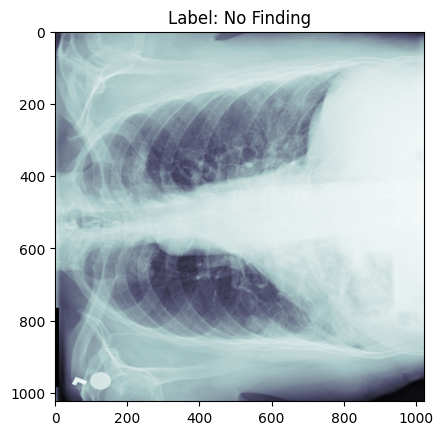

In [117]:
# patient_id = scan._meta["filename_or_obj"].split("/")[-1].split(".")[0]
plt.title(f"Label: {label[0]}")
display_scan = scan.squeeze().numpy()
# display_scan = np.transpose(display_scan, (1, 2, 0))
plt.imshow(display_scan, cmap="bone");

# Using `TTK`

In [ ]:
from omegaconf import DictConfig
import logging

# rtk
from rtk import datasets
from rtk.utils import hydra_instantiate

logging.getLogger("rtk.datasets").setLevel(logging.DEBUG)

transform = datasets.create_transforms(
    cfg, use_transforms=job_cfg.use_transforms
)
dataset = datasets.instantiate_image_dataset(
    cfg=cfg, save_metadata=True, transform=transform
)
train_dataset, test_dataset = dataset[0], dataset[1]

In [ ]:
transform.transforms

In [ ]:
train_dataset[0][0].shape

In [ ]:
train_loader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=train_dataset,
    pin_memory=torch.cuda.is_available(),
    shuffle=True,
)
test_loader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=test_dataset,
    pin_memory=torch.cuda.is_available(),
)
iterator = iter(train_loader)


## Get some samples

In [ ]:
scan, label = next(iterator)
scan.shape, label

In [ ]:
_filename = scan[0]._meta['filename_or_obj'].split('/')[-1]
patient_id = _filename.split('.')[0]
patient_id

In [ ]:
plt.title(f"Patient ID: {patient_id}")
display_scan = scan[0].numpy()
display_scan = np.transpose(display_scan, (1, 2, 0))
plt.imshow(display_scan, cmap="bone");

In [ ]:
display_scan